In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from hmmlearn import hmm

In [4]:
# Hidden Markov Model Modifiable Parameters
hidden_states = 3;
em_iterations = 75;
num_models = 8;

In [5]:
df = pd.read_csv('data/SPY.csv')

In [6]:
# Volatility is computed by obtaining variance between current close and prices of past 10 days
Volatility = []

# MA is the 10 day SMA
MA = []

# Return is the single-day percentage return
Return = []
ma_sum = 0;

# Warming up data for moving average and volatility calculations
for i in range (0, 10):
    Volatility.append(0);
    MA.append(0);
    Return.append(0);
    ma_sum += df['Close'][i];

# Filling in data for return, moving average, and volatility
for ind in df.index: 
    if ind >= 10:
        tail_close = df['Close'][ind-10];
        prev_close = df['Close'][ind-1];
        head_close = df['Close'][ind];
        ma_sum = (ma_sum - tail_close + head_close);
        ma_curr = ma_sum/10;
        MA.append(ma_curr);
        Return.append(((head_close-prev_close)/prev_close)*100);
        #Computing Volatility
        vol_sum = 0;
        for i in range (0,10):
            curr_vol = abs(ma_curr - df['Close'][ind-i]);
            vol_sum += (curr_vol ** 2);
        Volatility.append(vol_sum/10);

        

In [7]:
# Adding columns to dataframe
df['Volatility'] = Volatility;
df['MA'] = MA;
df['Return'] = Return;

In [8]:
# Dataframe readjustment
total_length = 6843
drop_length = 3508
training_length = 2706
test_length = total_length - drop_length - training_length
data_length = training_length+test_length
df = df.drop(range(0, drop_length));
df.index = range(0, data_length);


In [9]:
# Creating testing and training dataset
# 2000 datapoints in training, 838 datapoints in test
test = pd.DataFrame(df, index = range(training_length, data_length))
test.index = range(0,test_length)
training = df.drop(range(training_length, data_length))

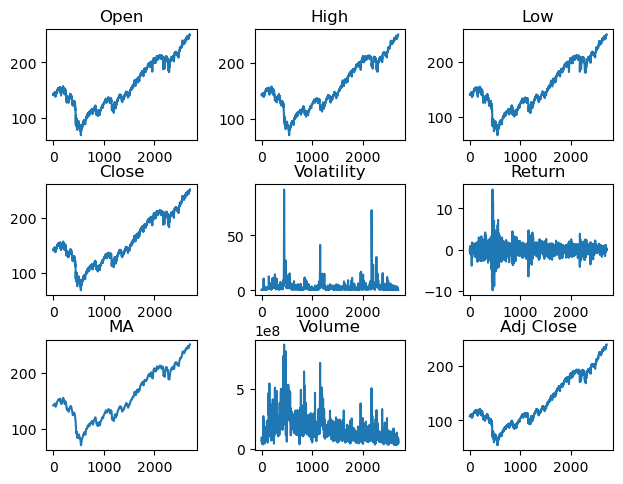

In [10]:
fig, a =  plt.subplots(3,3)
x = np.arange(1,5)
fig.tight_layout()
a[0][0].plot(range(0,training_length), training.iloc[:,1])
a[0][0].set_title('Open')
a[0][1].plot(range(0,training_length), training.iloc[:,2])
a[0][1].set_title('High')
a[0][2].plot(range(0,training_length), training.iloc[:,3])
a[0][2].set_title('Low')
a[1][0].plot(range(0,training_length), training.iloc[:,4])
a[1][0].set_title('Close')
a[1][1].plot(range(0,training_length), training.iloc[:,7])
a[1][1].set_title('Volatility')
a[1][2].plot(range(0,training_length), training.iloc[:,9])
a[1][2].set_title('Return')
a[2][0].plot(range(0,training_length), training.iloc[:,8])
a[2][0].set_title('MA')
a[2][1].plot(range(0,training_length), training.iloc[:,6])
a[2][1].set_title('Volume')
a[2][2].plot(range(0,training_length), training.iloc[:,5])
a[2][2].set_title('Adj Close')
plt.show()


In [11]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Volatility,MA,Return
0,2007-01-03,142.250000,142.860001,140.570007,141.369995,107.832581,94807600,0.238721,141.796999,-0.176529
1,2007-01-04,141.229996,142.050003,140.610001,141.669998,108.061440,69620600,0.237210,141.768999,0.212211
2,2007-01-05,141.330002,141.399994,140.380005,140.539993,107.199524,76645300,0.339690,141.600998,-0.797632
3,2007-01-08,140.820007,141.410004,140.250000,141.190002,107.695328,71655000,0.318505,141.505998,0.462508
4,2007-01-09,141.309998,141.600006,140.399994,141.070007,107.603760,75680100,0.333190,141.450999,-0.084988


In [12]:
# Creating the Hidden Markov Model
model = hmm.GaussianHMM(n_components = hidden_states, covariance_type="full", n_iter = em_iterations);
vol = training.iloc[:,7];
ret = training.iloc[:,9];
obs = [];
for i in range(0, len(vol)):
    arr = [];
    arr.append(vol[i]);
    arr.append(ret[i]);
    obs.append(arr);

# Fitting the model and obtaining predictions
model.fit(obs)
predictions = model.predict(obs)

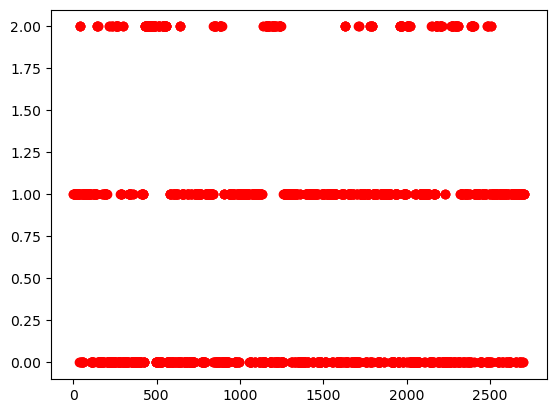

In [13]:
plt.plot(predictions, 'ro');

In [14]:
# Regime Classification
regime_vol = [];
regime_ret = [];
regime_count = [];
return_map = {};

for i in range(0, hidden_states):
    regime_vol.append(0);
    regime_ret.append(0);
    regime_count.append(0);

for i in range(0, len(predictions)):
    regime_count[predictions[i]] += 1;
    regime_vol[predictions[i]] += training.iloc[i, 7];
    regime_ret[predictions[i]] += training.iloc[i, 9];
    
    if not predictions[i] in return_map:
        return_map[predictions[i]] = [];
    return_map[predictions[i]].append(training.iloc[i,9]);
    
for i in range(0, hidden_states):
    regime_vol[i] = regime_vol[i] / regime_count[i];
    regime_ret[i] = regime_ret[i] / regime_count[i];

In [15]:
max_occurrence = np.argmax(regime_count)
for i in range(0, hidden_states):
    print("Regime {0}".format(i))
    print("Avg Vol: {0}".format(regime_vol[i]));
    print("Avg Return: {0}".format(regime_ret[i]));
    print("Occurrence: {0}\n".format(regime_count[i]));

Regime 0
Avg Vol: 3.473911201667222
Avg Return: 0.03984471599660957
Occurrence: 1140

Regime 1
Avg Vol: 0.9438078388265714
Avg Return: 0.04635054516906783
Occurrence: 1221

Regime 2
Avg Vol: 13.63465684440595
Avg Return: -0.06600020310820759
Occurrence: 345



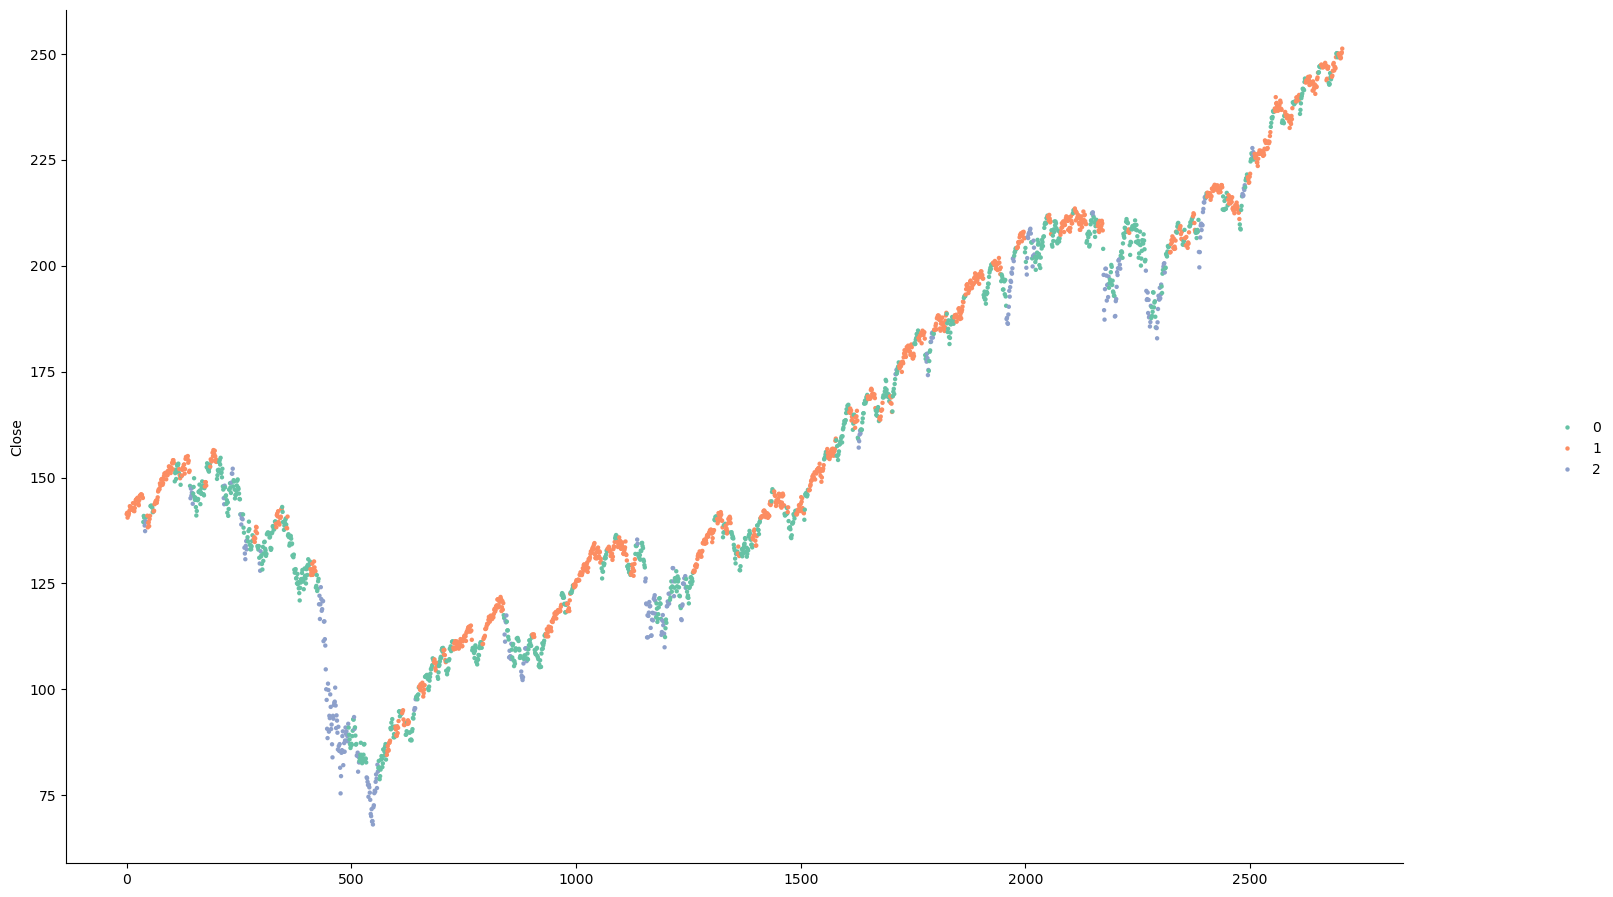

In [16]:
plot = sns.relplot(x=range(0,training_length), y="Close", data=training, hue=predictions, 
            linewidth = 0, palette="Set2", s = 10);
plot.fig.set_size_inches(18,10)

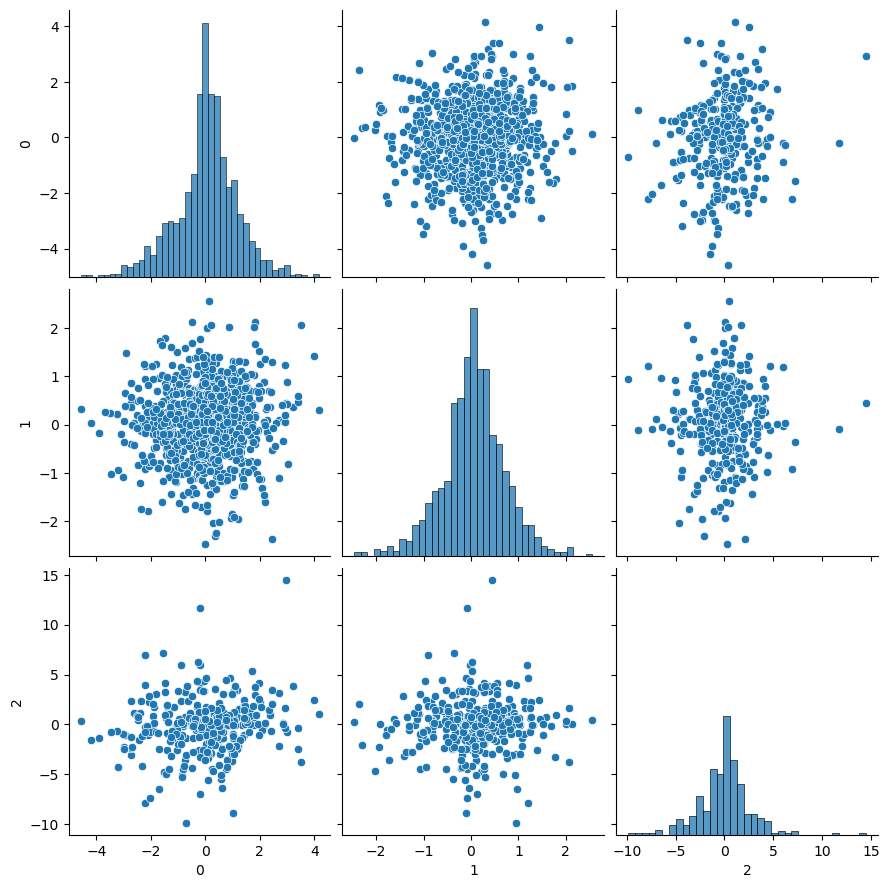

In [17]:
returns = pd.DataFrame(data = return_map[max_occurrence])
for i in range(0, hidden_states):
    if(i is not max_occurrence):
        returns[i] = pd.Series(return_map[i]);

sns.pairplot(data = returns, height=3);


In [18]:
distribution = model.get_stationary_distribution();
for i in range(0, hidden_states):
    print("Regime {0}: {1}".format(i, distribution[i]));


Regime 0: 0.4237908632287791
Regime 1: 0.4461752772335068
Regime 2: 0.13003385953771404


In [19]:
print("Model Score: {0}".format(model.score(obs)));

Model Score: -8662.973832534624


[Text(1, 0, '1'), Text(2, 0, '0'), Text(3, 0, '2')]

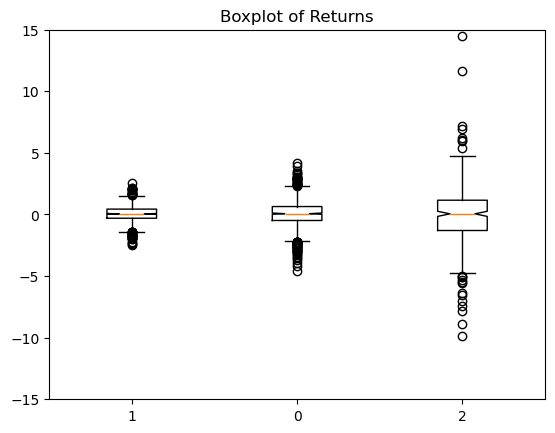

In [20]:
# Boxplot of returns
fig, ax = plt.subplots()
ax.set(ylim=(-15, 15))
ax.set_title("Boxplot of Returns")
ax.boxplot(return_map.values(), notch=True, vert = True, autorange = True)
ax.set_xticklabels(return_map.keys())

In [21]:
returns = pd.read_csv('data/factors.csv').drop("Unnamed: 0", axis=1)

In [22]:
df.to_csv('data/SPY_ADV.csv')

In [23]:
returns

,Date,Momentum,BookValue,AQR,SPY,FamaFrench,Growth,ModifiedFama,Carhart
0,2007-01-03,-0.325891,-0.156088,-0.190234,-0.176529,-0.381767,-2.844111,-0.329604,-0.442986
1,2007-01-04,-1.339746,-0.557835,-2.273664,0.212211,-0.950948,-1.454814,-0.903854,-1.271826
2,2007-01-05,-0.424333,-0.941898,-1.097538,-0.797632,-0.063301,-1.201175,0.076072,-0.509877
3,2007-01-08,0.484884,-0.031855,0.572755,0.462508,-0.205961,0.207839,-0.034745,0.143852
4,2007-01-09,0.075412,-0.309927,-0.056759,-0.084988,0.047450,0.405236,0.414645,0.115895
...,...,...,...,...,...,...,...,...,...
2681,2017-08-25,0.340010,-0.341642,0.213778,0.233613,-0.395026,0.050292,0.394295,0.230632
2682,2017-08-28,-0.225368,0.420116,0.187518,0.004093,0.472693,0.202439,0.187487,0.033359
2683,2017-08-29,-0.006172,-0.082503,0.241719,0.114486,-0.050875,0.114404,0.083524,0.301750
2684,2017-08-30,-0.241247,-0.089570,-0.029641,0.473755,-0.232705,0.520399,-0.364990,-0.232389


In [24]:
training['Momentum'] = returns.iloc[:, 1]
training['BookValue'] = returns.iloc[:, 2]
training['AQR'] = returns.iloc[:, 3]
training['FamaFrench'] = returns.iloc[:, 5]
training['Growth'] = returns.iloc[:, 6]
training['ModifiedFama'] = returns.iloc[:, 7]
training['Carhart'] = returns.iloc[:, 8]

In [25]:


model_returns = {}

#Initialize
for i in range(1, 1+ num_models):
    name = returns.columns[i]
    model_returns[name] = []
    
for key in model_returns.keys():
    for i in range(0, hidden_states):
        model_returns[key].append(0)

for i in range(0, len(returns)):
    for j in range(1, num_models+1):
        regime = predictions[i]
        model_returns[returns.columns[j]][regime] += returns.iloc[i, j]

In [26]:
for i in range(0, num_models):
    for j in range (0, hidden_states):
        model_returns[returns.columns[1+i]][j] /= regime_count[j]

In [27]:
model_returns = pd.DataFrame(data=model_returns)
model_returns.to_csv('data/regime_models.csv')
model_returns.head()

,Momentum,BookValue,AQR,SPY,FamaFrench,Growth,ModifiedFama,Carhart
0,0.000025,-0.035360,-0.013932,0.039664,-0.016773,0.080072,0.000716,-0.013217
1,-0.006197,-0.050962,-0.033275,0.045281,0.031735,0.085493,0.016581,0.010264
2,-0.072686,-0.038280,-0.011288,-0.066000,0.031351,-0.028286,0.033456,-0.047684


In [28]:
predictions_df = pd.DataFrame(data = predictions)
predictions_df.to_csv('data/regime_predictions.csv')

In [29]:
transition = pd.DataFrame(data = model.transmat_)
transition.to_csv('data/transition.csv')

In [30]:
returns = pd.DataFrame()
returns['dates'] = pd.read_csv('results/CSV/HMM.csv').iloc[:,0]
returns['hmm'] = pd.read_csv('results/CSV/HMM.csv').iloc[:,1]
returns['ff3'] = pd.read_csv('results/CSV/FF3.csv').iloc[:,1]
returns['mff'] = pd.read_csv('results/CSV/MFF.csv').iloc[:,1]
returns['carhart'] = pd.read_csv('results/CSV/carhart.csv').iloc[:,1]
returns['aqr'] = pd.read_csv('results/CSV/aqr.csv').iloc[:,1]
returns['growth'] = pd.read_csv('results/CSV/growth.csv').iloc[:,1]

In [31]:
for i in range(1, returns.shape[1]):
    returns.iloc[0, i] = 100000
    
for i in range(1, returns.shape[0]):
    for j in range(1, returns.shape[1]):
        returns.iloc[i, j] = returns.iloc[i-1, j] * (100 + returns.iloc[i,j])/100


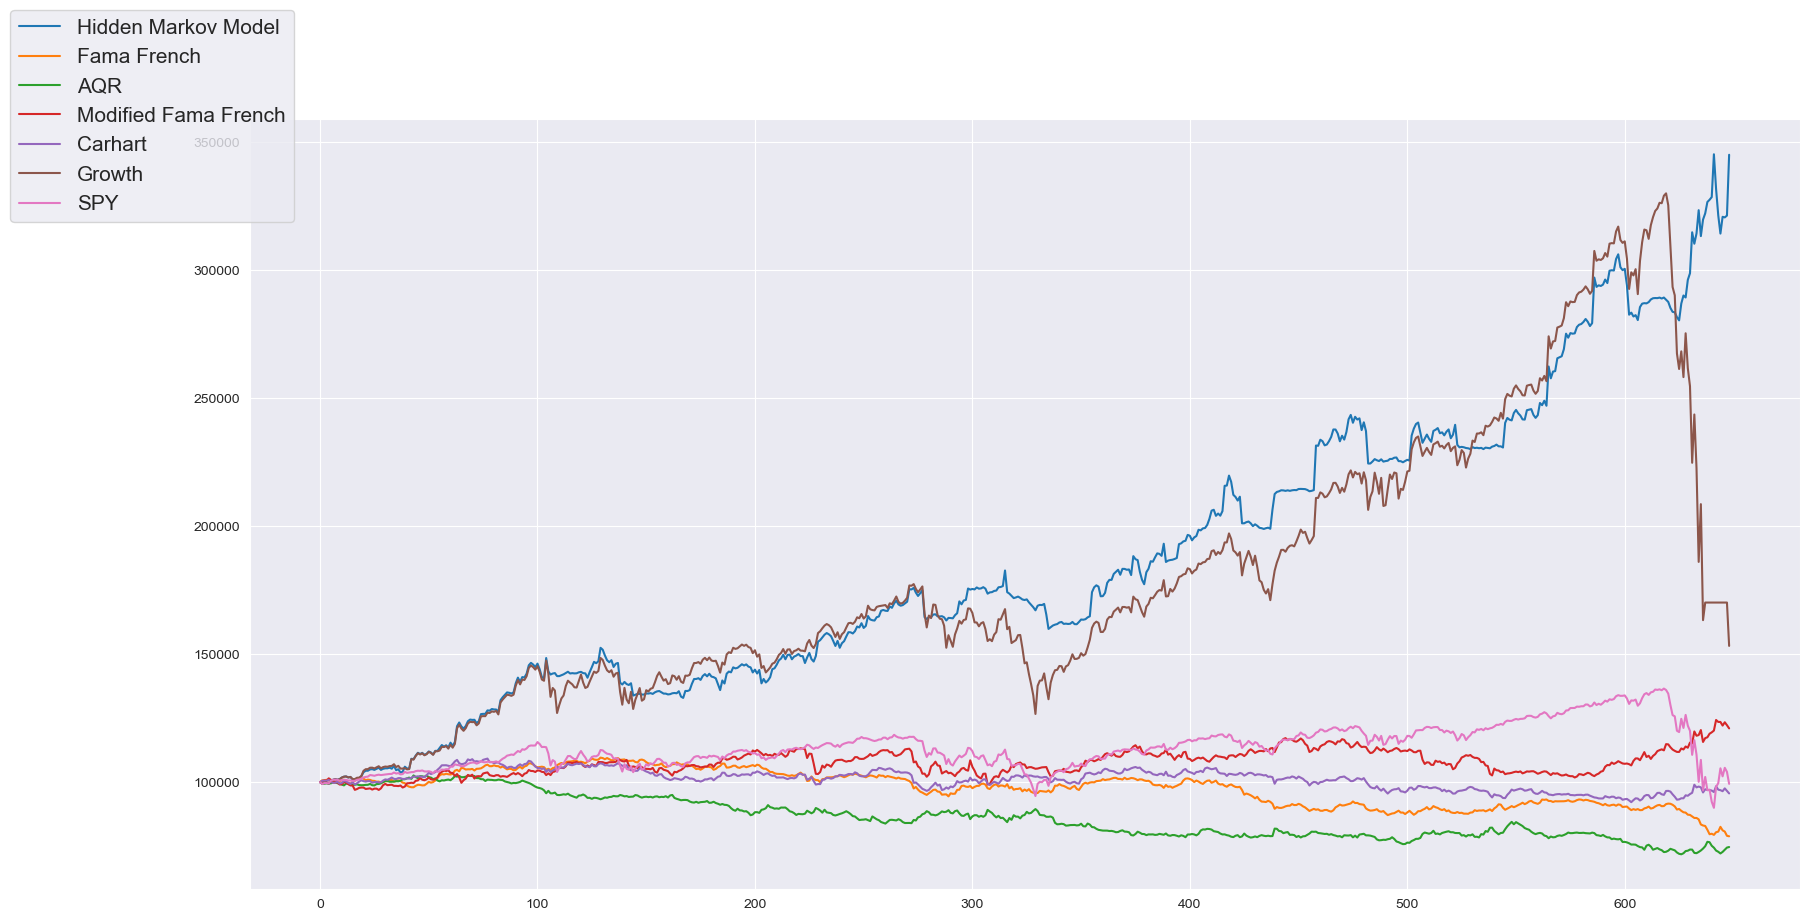

In [32]:
sns.set_style("darkgrid")
plot = plt.figure(figsize=(20,10)) 
plt.plot(returns['hmm'], label="Hidden Markov Model",)
plt.plot(returns['ff3'], label="Fama French",)
plt.plot(returns['aqr'], label="AQR",)
plt.plot(returns['mff'], label="Modified Fama French")
plt.plot(returns['carhart'], label="Carhart")
plt.plot(returns['growth'], label='Growth')
plt.plot((np.asarray(df.iloc[2686:]['Close']) * 100000/df.iloc[2686]['Close']), label='SPY')
plot.legend(loc=2, prop={'size': 15})
plt.show()